In [1]:
from fastai.text import *   # Quick access to NLP functionality
from fastai.datasets import *

In [12]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=32)

In [13]:
df.head(5)

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [14]:
#save
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [16]:
#load
data_lm = load_data(path, 'data_lm_export.pkl')
data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

# Building a Language Model

In [3]:
# Learn the model using transfer learning
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.310412,3.884722,0.284473,00:27


In [19]:
learn.unfreeze()
learn.fit(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 4.00 GiB total capacity; 2.85 GiB already allocated; 13.47 MiB free; 63.94 MiB cached)

In [ ]:
# Predict
learn.predict("This is a review about", n_words=10)

In [ ]:
#save ENCODER
learn.save_encoder('ft_enc')

# Building a classifier

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

In [ ]:
data_clas.show_batch()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

In [ ]:
# Predict
learn.predict("This was a great movie!")

# Text Classification Interpretation

In [ ]:
import matplotlib.cm as cm

txt_ci = TextClassificationInterpretation.from_learner(learn) # TextClassificationInterpretation can be used ONLY once we train a text classification model.
test_text = "Zombiegeddon was perhaps the GREATEST movie i have ever seen!"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

In [ ]:
txt_ci.intrinsic_attention(test_text)[1]

In [ ]:
txt_ci.show_top_losses(5) # If max_len=None, it will display all tokens.

# Using DataBLock API

# So another approach to doing this is to just decide:

#### What kind of list you're creating (i.e. what's your independent variable)? So in this case, my independent variable is text.
#### What is it coming from? A CSV.
### How do you want to split it into validation versus training? So in this case, column number two was the is_valid flag.
### How do you want to label it? With positive or negative sentiment, for example. So column zero had that.
### Then turn that into a data bunch.

In [ ]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language Model --> Guessing the next word of the movie review!!
### Accuracy: 0.3 or more is usually pretty good --> Predict the next word in 1/3 of the time!

In [2]:
bs = 20

In [3]:
path = untar_data(URLs.IMDB)
path.ls()

[WindowsPath('C:/Users/bokhy/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/bokhy/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/bokhy/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/bokhy/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/bokhy/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/bokhy/.fastai/data/imdb/train'),
 WindowsPath('C:/Users/bokhy/.fastai/data/imdb/unsup')]

In [4]:
(path/'train').ls()

[WindowsPath('C:/Users/bokhy/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('C:/Users/bokhy/.fastai/data/imdb/train/neg'),
 WindowsPath('C:/Users/bokhy/.fastai/data/imdb/train/pos'),
 WindowsPath('C:/Users/bokhy/.fastai/data/imdb/train/unsupBow.feat')]

In [ ]:
# Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, 
# we'll need to adjust the parameters of our model by a little bit

In [5]:
# This is a text databunch model (sames as above)
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [6]:
# This it to load the above databunch (you can skip above one for upcoming models)
data_lm = load_data(path, 'data_lm.pkl', bs=bs)
data_lm.show_batch()

idx,text
0,"later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj"
1,"the xxmaj dark "" that i actually remember seeing in the theater . \n \n xxmaj the remaining 2 were equally as bad . "" xxmaj creatures from the xxmaj abyss "" being probably the worst of the bunch . xxmaj since they were all bad that is n't saying much . xxmaj but its stupidity , bad acting , terrible effects and retarded storyline actually made this one"
2,"almost 500 movies this is the only non - short i 've given a 1 / 10 . \n \n i have n't seen any other low - budget xxmaj asian warrior flicks , so i guess there 's even worse things out there ! xxmaj scary ... \n \n xxup :p xxbos so if a guy meets you and he says ' i want you to look"
3,"enough to xxup not dislike a film solely due to its lack of stars or professional look ? xxmaj well , if you said yes then you should have a mind open enough to handle this one . xxmaj this film is an almost 100 % accurate dramatization of xxmaj dahmer 's adult life and subsequent murder spree , and is styled as an autobiography . xxmaj it is n't"
4,"never been ' average ' . xxmaj when xxmaj madonna performs , she gives 120 % - everything is bigger , better , theatrical and meaningful . xxmaj she takes inspirations from xxmaj east , xxmaj west , and makes then unique . xxmaj everything is given a deeper meaning , and xxmaj the xxmaj confessions xxmaj tour is not different . xxmaj from the very beginning , you find"


In [8]:
# Learn the model using transfer learning
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [9]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


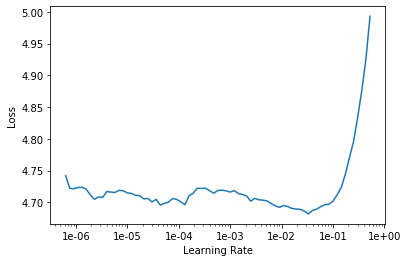

In [10]:
learn.recorder.plot(skip_end=15)

In [11]:
# fine-tuning the last layers
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.406041,4.224589,0.284489,3:16:12


In [12]:
# Save the model
learn.save('fit_head')

#### Load Model for later use (e.x. to improve accuracy)

In [ ]:
learn.load('fit_head')

In [ ]:
# To complete the fine-tuning, we can then unfeeze and launch a new training.
# This takes about 3-4 hours
# 0.3 or more is usually pretty good --> Predict the next word in 1/3 of the time!
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))
learn.save('fine_tuned')

#### Predict

In [13]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [14]:
learn.predict(TEXT, N_WORDS, temperature=1.1, min_p = 0.001)
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because i was shocked by the positive reviews and received reviews from i - do - not i was sick of this movie . i 'm not especially my roommate who was really surprised . At the time i saw
I liked this movie because it was not made when Xxbos The Xxbos Be an all - star movie by Van Damme and Van Damme 's career had me all over the window . 
 
  The


#### We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. 
#### For the next part, we don't care about the part that tries to guess the next word.

In [15]:
learn.save_encoder('fine_tuned_enc')

# Classifer Model

In [ ]:
# Now, we'll create a new data object that only grabs the labelled data and keeps those labels.

In [16]:
data_clas = (TextList.from_csv(path, vocab=data_lm.vocab) #grab all the text files in path
             # Vocab variable: we want to make sure that it uses exactly the same vocab that are used for the language model. 
             # If word number 10 was the in the language model, we need to make sure that word number 10 is the in the classifier. 
             # Because otherwise, the pre-trained model is going to be totally meaningless
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [18]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
# or try this
# data_clas = TextClasDataBunch.load(path, 'data_clas.pkl', bs=bs)

In [19]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj warning : xxmaj does contain spoilers . \n \n xxmaj open xxmaj your xxmaj eyes \n \n xxmaj if you have not seen this film and plan on doing so , just stop reading here and take my word for it . xxmaj you have to see this film . i have seen it four times so far and i still have n't made up my",pos
xxbos * * * xxup spoilers * * * * * * xxup spoilers * * * xxmaj continued ... \n \n xxmaj from here on in the whole movie collapses in on itself . xxmaj first we meet a rogue program with the indication we 're gon na get ghosts and vampires and werewolves and the like . xxmaj we get a guy with a retarded accent talking,neg
"xxbos xxmaj to be a xxmaj buster xxmaj keaton fan is to have your heart broken on a regular basis . xxmaj most of us first encounter xxmaj keaton in one of the brilliant feature films from his great period of independent production : ' xxmaj the xxmaj general ' , ' xxmaj the xxmaj navigator ' , ' xxmaj sherlock xxmaj jnr ' . xxmaj we recognise him as",neg
"xxbos xxmaj anyone who visited drive - ins in the 1950s , 60s , and 70s , must have seen a film or two by xxmaj american xxmaj international xxmaj pictures , a distributor that resembled 1980s giant xxmaj cannon xxmaj films . xxmaj wherever movie - goers ventured , xxup aip would be right there to supply the latest en vogue titles - in the 50s came horror movies",neg


In [21]:
# creating a text classifier learner
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
# If you're overfitting, you can increase "drop_mult"

In [22]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj story of a man who has unnatural feelings for a pig . xxmaj starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turned into an insane , violent mob by the crazy xxunk of it 's singers . xxmaj unfortunately it stays absurd the xxup whole time with no general narrative eventually making it just too off putting . xxmaj even those from the era should be turned off . xxmaj the cryptic dialogue would make xxmaj shakespeare seem easy to a third grader . xxmaj on a technical level it 's better than you might think with some good cinematography by future great xxmaj vilmos xxmaj zsigmond . xxmaj future stars xxmaj sally xxmaj kirkland and xxmaj frederic xxmaj forrest can be seen briefly .,xxbos xxmaj airport ' 77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman xxmaj philip xxmaj steven

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


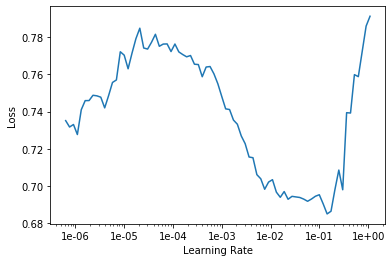

In [24]:
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.451934,0.357454,0.851360,24:01


In [26]:
## Save: No need to run this if you want to train with your own data
learn.save('first')

In [27]:
learn.load('first');

In [ ]:
# I'm not going to say unfreeze. 
# Instead, I'm going to say freeze_to. 
# What that says is unfreeze the last two layers, don't unfreeze the whole thing. 
# We've just found it really helps with these text classification not to unfreeze the whole thing, 
# but to unfreeze one layer at a time.

In [ ]:
# 1. unfreeze the last two layers
# 2. train it a little bit more
# 3. unfreeze the next layer again
# 4. train it a little bit more
# 5. unfreeze the whole thing
# 6. train it a little bit more

In [28]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.348551,0.236512,0.907800,25:45


In [29]:
learn.save('second')
learn.load('second');

In [30]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 92.00 MiB (GPU 0; 4.00 GiB total capacity; 2.85 GiB already allocated; 21.47 MiB free; 58.27 MiB cached)

In [ ]:
learn.save('third')
learn.load('third');

In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: CUDA out of memory. Tried to allocate 92.00 MiB (GPU 0; 4.00 GiB total capacity; 2.83 GiB already allocated; 19.47 MiB free; 79.78 MiB cached)

In [32]:
learn.predict("I really loved that movie, it was awesome!")

C:\Users\bokhy\Anaconda3\envs\deeplearning\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


RuntimeError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 4.00 GiB total capacity; 2.83 GiB already allocated; 19.47 MiB free; 80.10 MiB cached)

# Text Classification Interpretation

In [33]:
import matplotlib.cm as cm

txt_ci = TextClassificationInterpretation.from_learner(learn) # TextClassificationInterpretation can be used ONLY once we train a text classification model.
test_text = "Zombiegeddon was perhaps the GREATEST movie i have ever seen!"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

C:\Users\bokhy\Anaconda3\envs\deeplearning\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavio

In [34]:
txt_ci.intrinsic_attention(test_text)[1] # Numeric interpretation

C:\Users\bokhy\Anaconda3\envs\deeplearning\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavio

tensor([0.2981, 0.2924, 1.0000, 0.2977, 0.4379, 0.1884, 0.2399, 0.4287, 0.3837,
        0.2329, 0.1449, 0.1018, 0.0713, 0.1004], device='cuda:0')

In [35]:
txt_ci.show_top_losses(5) # If max_len=None, it will display all tokens.

Text,Prediction,Actual,Loss,Probability
"xxbos i went to see this 3 nights ago here in xxmaj cork , xxmaj ireland . xxmaj it was the world premiere of it , in the tiny cinema in the xxmaj xxunk xxmaj arts xxmaj centre as part of the xxmaj cork xxmaj film xxmaj festival . \n \n i found "" xxmaj strange xxmaj fruit "" to be an excellent movie . xxmaj it is a",pos,neg,8.45,0.00
"xxbos xxmaj this movie was pure genius . xxmaj john xxmaj waters is brilliant . xxmaj it is hilarious and i am not sick of it even after seeing it about 20 times since i bought it a few months ago . xxmaj the acting is great , although xxmaj ricki xxmaj lake could have been better . xxmaj and xxmaj johnny xxmaj depp is magnificent . xxmaj he is",pos,neg,7.91,0.00
xxbos xxmaj this is definitely one of the best xxmaj kung fu movies in the history of xxmaj cinema . xxmaj the screenplay is really well done ( which is not often the case for this type of movies ) and you can see that xxmaj chuck ( in one of his first xxunk a great actor . xxmaj the final fight with the xxunk deputy in the bullring is,pos,neg,7.43,0.00
"xxbos i really liked this quirky movie . xxmaj the characters are not the bland beautiful people that show up in so many movies and on xxup tv . xxmaj it has a realistic edge , with a captivating story line . xxmaj the main title sequence alone makes this movie fun to watch .",pos,neg,6.78,0.00
"xxbos xxmaj this has to be one of , if not xxup the greatest xxmaj mob / xxmaj crime films of all time . xxmaj every thing about this movie is great , the acting in this film is of true quality ; xxmaj master p 's acting skills make you actually believe he is xxmaj italian ! xxmaj the cinematography is excellent too , probably the best ever .",pos,neg,6.37,0.00
